# Modeling and Data Analysis

This is an example "walk through" of one of the [labs](https://github.com/sspickle/instrumentation-projects/blob/master/proj1/Arduino%20as%20a%20Laboratory%20Interface.ipynb) we do in our sophmore [electronics course](https://github.com/sspickle/instrumentation-projects). The course has two primary learning outcomes:

Students learn to apply:

1. a variety of computational modeling and statistical techniques centering on experimental data analysis AND
2. physics concepts from intro electricity and magnetism in a laboratory setting through the use of electronics and microcontrollers

A typical lab would involve

1. building a circuit meant to accomplish some experimental goal, 
2. writing a microcontroller program to run the experiment and collect data, 
3. apply a statistical/analysis approach to make inferences from the collected data

## A generative model

One of the important ideas we study is the notion of a generative model. This is a mathematical model of the system that includes some measure of randomness or noise, usually represented as a normal distribution superposed with an exact deterministic model. A very simple example from the intro physics course is Ohm's Law. If we measure the voltage accross a resistor in the lab we'd expect it to depend on the current in the expected way:

$$ V = I R $$

A generative model might look like this:

$$ V = I R + \delta V$$

where $\delta V$ is a random contribution from noise. We can model this in python using the numpy, scipy, and matplotlib libraries.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

In [9]:
#
# first let's create an array of current values:
#

Rg = 1000.0  # 1 k Ohm
sig = 0.01 # 5 mV

I = np.linspace(0, 0.010, 11)
I

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 ])

In [10]:
V = I * Rg + sig*np.random.randn(len(I))
V

array([-0.01301625,  1.02608187,  2.01167295,  3.002753  ,  4.00578564,
        4.99118966,  5.99934857,  7.01152556,  7.98292863,  8.99783757,
        9.9990597 ])

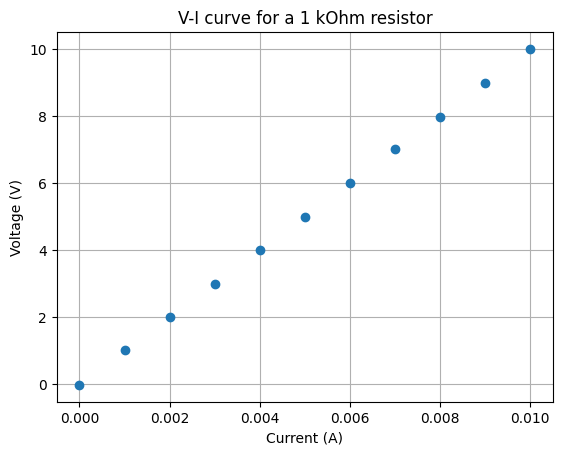

In [11]:
plt.plot(I, V, 'o')
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.title("V-I curve for a 1 kOhm resistor")
plt.grid()

In [12]:
#
# Let's define the model function
#

def OhmsLaw(I, R, offset):
    return I * R + offset

# curve_fit takes 1) function, 2) x, 3) y, 4) initial guess (p0, optional) 5) uncertainties (sigma, optional)
(R, offset), cov = curve_fit(OhmsLaw, I, V, p0=[Rg,0], sigma=np.ones(len(I))*sig) 

dR,doffset = np.sqrt(np.diag(cov))          # returns tuple of parameters and covariance matrix

print("R = %f +/- %f Ω" % (R, dR))
print("offset = %f +/- %f V" % (offset, doffset))

R = 998.838888 +/- 1.174504 Ω
offset = 0.007184 +/- 0.006948 V


The value of the generative model is the ability to validate the data analysis and inference approach. If you can generate data with the same statistical properties as the data you *expect* to measure, and the data analysis approach produces inferences that are consistent with the generative model, it lends credibility to that process.




## The Schockley Equation

The first bit of actual "electronics" we encounter in the course is the PN junction, and the form of a light emitting diode (LED). These are non-linear devices that very nearly obey a theoretical relationship developed by Shockley:

$$ I = I_o (e^{\frac{q V_d}{\eta k_b T}}-1) $$

Where $V_d$ is the voltage drop across the PN junction, $\eta$ is the "emission coefficient", $q$ is the electron charge, $k_b$ is the Boltzmann constant and $T$ is the absolute temperature. Notice that when the LED is drawing appreciable current we're in a domain where $q V_d/\eta$ is much greater than $k_b T$, so the $-1$ in parenthesis is negligable compared to the exponential. So our simplifed ideal diode model becomes:

$$ I \approx I_o e^{\frac{ q V_d}{\eta k_b T}} $$

Now, solve this for $V_d$ as a function of $I$:

$$ V_d = \frac{\eta k_b T}{q} \ln(I/I_o)$$

You can think of this as the "Ohm's Law" of an LED. We can simplify this by defining $A$ and $B$ like so:

$$ A=\frac{\eta k_b T}{q}$$

$$B = -A \ln(I_o) $$

which gives:

$$ V_d = A \ln(I) + B $$

If we graph $V_d$ vs $I$ we should get a straight line! Nice.



# A Generative Model

Let's build a generative model for this theory. Usually $\eta$ is not too far from unity, and $I_0$ is extremely small. For the purposes of having a generative model, let's pick $\eta \approx 1.5$ and $I_0 \approx 1\times 10^{-21}$

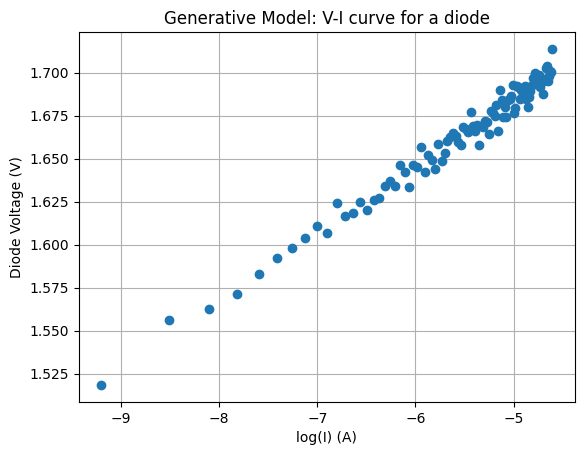

In [13]:
Igen = np.linspace(0, 0.010, 100)[1:] # exclude I=0
kbToQ = 0.0259 # V
eta_gen = 1.5
I0_gen = 1e-21
Agen = eta_gen * kbToQ
Bgen = -Agen*np.log(I0_gen)
sig = 0.005 # ~2 x minimum resolution of the ADC
Vgen = Agen * np.log(Igen) + Bgen + sig*np.random.randn(len(Igen))

plt.plot(np.log(Igen), Vgen, 'o', label="gen model")
plt.xlabel('log(I) (A)')
plt.ylabel('Diode Voltage (V)')
plt.title("Generative Model: V-I curve for a diode")
plt.grid()

So, that doesn't look completely crazy. Let's fit that and see how it goes:

A = 0.039004 +/- 0.000562
B = 1.879306 +/- 0.003172 V
chiSq = 1.063908


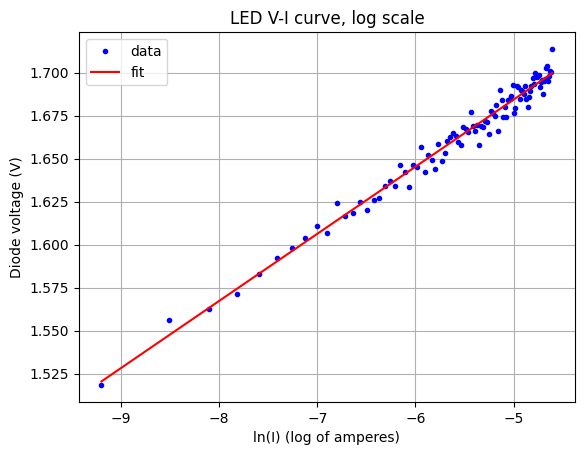

In [14]:
def linear_model(lnI, A, B):
    return A*lnI + B

lnI = np.log(Igen)

(A, B), cov = curve_fit(linear_model, lnI, Vgen, sigma=np.ones(len(Vgen))*sig)
dA,dB = np.sqrt(np.diag(cov))          # returns tuple of parameters and covariance matrix

plt.plot(lnI,Vgen,'b.', label="data")

Vth = linear_model(lnI, A, B)
plt.plot(lnI, Vth, 'r-',label="fit")
plt.title("LED V-I curve, log scale")
plt.ylabel("Diode voltage (V)")
plt.xlabel("ln(I) (log of amperes)")
plt.grid()
plt.legend()

print("A = %f +/- %f" % (A, dA))
print("B = %f +/- %f V" % (B, dB))

chiSq = np.sum(((Vgen - linear_model(lnI, A, B))/sig)**2)
print("chiSq = %f" % (chiSq/(len(Vgen)-2)))


In [15]:
eta = A/kbToQ
print(eta)

lnI0 = -B/A
I0 = np.exp(lnI0)
print(I0)

1.5059548570023442
1.1878827187694437e-21


(array([   3.,   14.,   36.,   88.,  209.,  377.,  630.,  896., 1233.,
        1414., 1298., 1222.,  977.,  742.,  452.,  218.,  120.,   42.,
          20.,    9.]),
 array([1.42785396, 1.4355595 , 1.44326504, 1.45097057, 1.45867611,
        1.46638165, 1.47408719, 1.48179272, 1.48949826, 1.4972038 ,
        1.50490933, 1.51261487, 1.52032041, 1.52802595, 1.53573148,
        1.54343702, 1.55114256, 1.55884809, 1.56655363, 1.57425917,
        1.58196471]),
 <BarContainer object of 20 artists>)

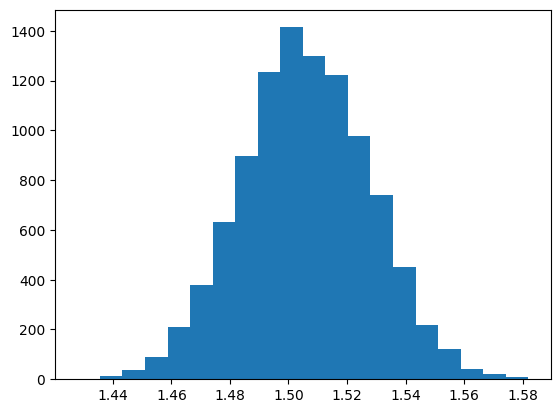

In [16]:
Amc = A + dA*np.random.normal(size=10000)
Bmc = B + dB*np.random.normal(size=10000)
etaMC = Amc/kbToQ
I0MC = np.exp(-Bmc/Amc)
plt.hist(etaMC, bins=20)

(array([2.207e+03, 3.303e+03, 1.957e+03, 1.108e+03, 6.130e+02, 3.500e+02,
        1.640e+02, 1.200e+02, 6.200e+01, 4.600e+01, 1.400e+01, 1.900e+01,
        1.300e+01, 6.000e+00, 3.000e+00, 6.000e+00, 2.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00]),
 array([8.45239951e-23, 6.88698153e-22, 1.29287231e-21, 1.89704647e-21,
        2.50122063e-21, 3.10539478e-21, 3.70956894e-21, 4.31374310e-21,
        4.91791726e-21, 5.52209141e-21, 6.12626557e-21, 6.73043973e-21,
        7.33461389e-21, 7.93878804e-21, 8.54296220e-21, 9.14713636e-21,
        9.75131052e-21, 1.03554847e-20, 1.09596588e-20, 1.15638330e-20,
        1.21680071e-20]),
 <BarContainer object of 20 artists>)

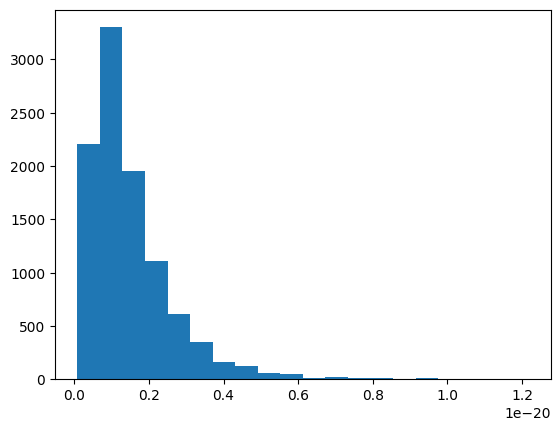

In [17]:
plt.hist(I0MC, bins=20)

# Experiment

The basic experiment involves driving an LED with varying amounts of current and measuring the voltage drop to witness the non-linear behavior of the device.

## First Pass

We do a "first pass" of this experiment early in the course (first lab!) as an introduction to microcontrollers (e.g., Arduino Uno) and collecting data. The circuit the students build looks like this. Notice that since the Uno has no D/A converter we have to drive the LED with a PWM pin which requires substantial filtering.

![circuit](proj1.png)

## Improvement

Later in the course, after we've learned a bit about transistors, we work with this version of the circuit:

![circuit2](proj1a.png)

This is a much better circuit because it makes the filtering much easier with low currents (and a much smaller capacitor). It also highlights the advantage of driving a load from the Arduino using a BJT with a ~200x current gain. As far as data analysis is concerned there's very little difference between the two circuits, but the data we get is much cleaner with this version.

The Arduino code typically looks like this:

![code](micro-code.png)

Let's go ahead and load that data!


In [18]:
df = pd.read_csv('LED_data.csv')
df.head()

,drive,A0,A1
0,0,0,726
1,5,0,725
2,10,0,725
3,15,0,725
4,20,0,724


Text(0, 0.5, 'Values (raw)')

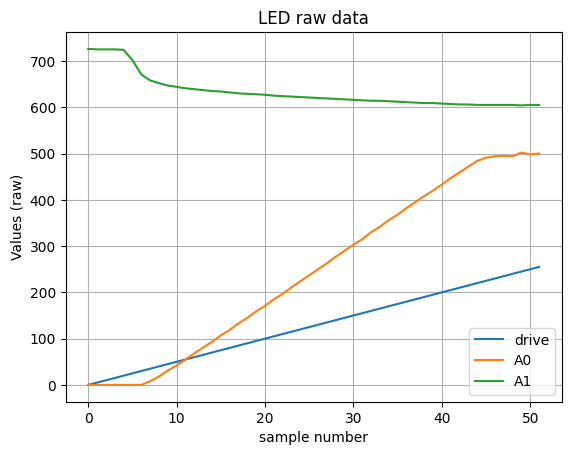

In [19]:
df.plot()
plt.grid()
plt.title("LED raw data")
plt.xlabel("sample number")
plt.ylabel("Values (raw)")

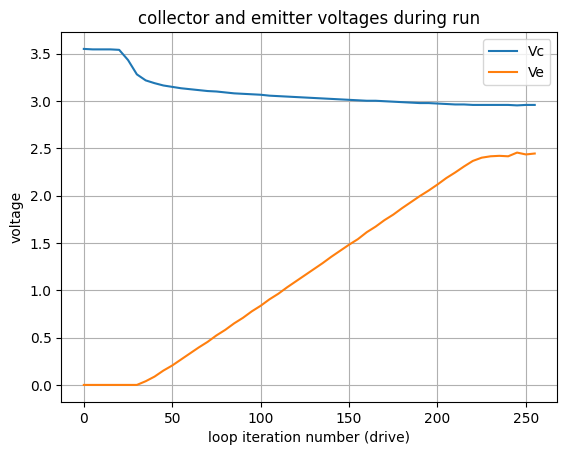

In [20]:
vc = df.A1*5/1023
ve = df.A0*5/1023
plt.plot(df.drive, vc, label="Vc")
plt.plot(df.drive, ve, label="Ve")
plt.grid()
plt.title("collector and emitter voltages during run")
plt.xlabel("loop iteration number (drive)")
plt.ylabel("voltage")
plt.legend()

Text(0, 0.5, 'Diode current (mA)')

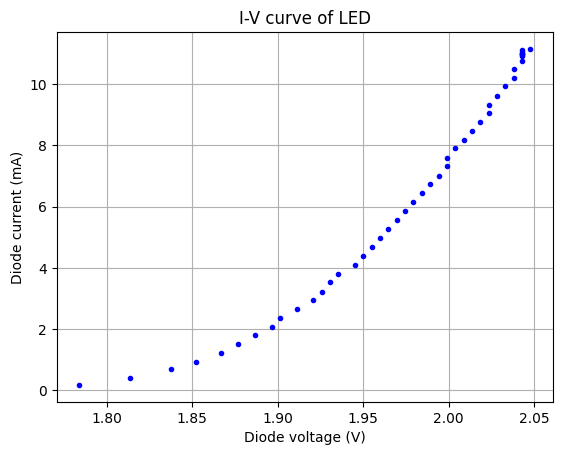

In [21]:
Re = 220
Id = ve.values/Re
Vd = 5-vc.values
valid = (Id > 0) # boolean array, true when Id > 0
plt.plot(Vd[valid],Id[valid]*1000,'b.')
plt.grid()
plt.title("I-V curve of LED")
plt.xlabel("Diode voltage (V)")
plt.ylabel("Diode current (mA)")

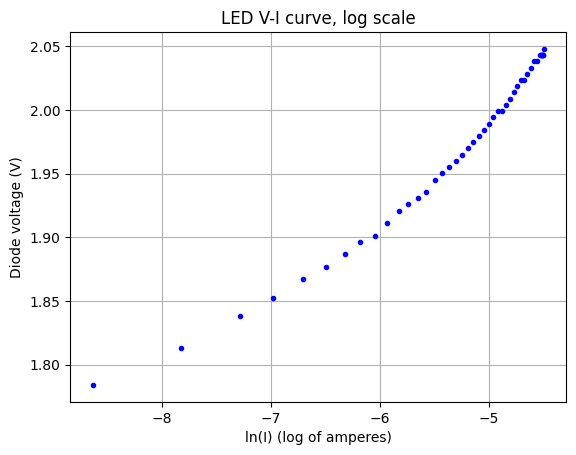

In [22]:
lnI = np.log(Id[valid])
plt.plot(lnI,Vd[valid],'b.')
plt.title("LED V-I curve, log scale")
plt.ylabel("Diode voltage (V)")
plt.xlabel("ln(I) (log of amperes)")
plt.grid()

A = 0.071360 +/- 0.002238
B = 2.351090 +/- 0.012183 V
chiSq = 8.089946


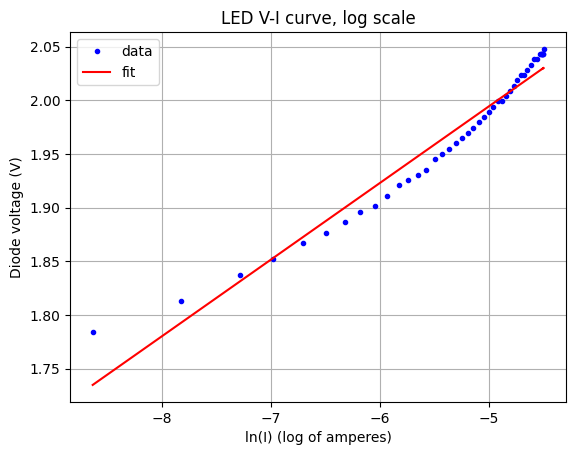

In [23]:
def linear_model(lnI, A, B):
    return A*lnI + B

lnI = np.log(Id[valid])

A0 = (Vd[valid][-1] - Vd[valid][0])/(lnI[-1] - lnI[0])
B0 = Vd[valid][0] - A0*lnI[0]

(A, B), cov = curve_fit(linear_model, lnI, Vd[valid], p0=[A0,B0], sigma=np.ones(len(Vd[valid]))*sig)
dA,dB = np.sqrt(np.diag(cov))          # returns tuple of parameters and covariance matrix

plt.plot(lnI,Vd[valid],'b.', label="data")

Vth = linear_model(lnI, A, B)
plt.plot(lnI, Vth, 'r-',label="fit")
plt.title("LED V-I curve, log scale")
plt.ylabel("Diode voltage (V)")
plt.xlabel("ln(I) (log of amperes)")
plt.grid()
plt.legend()

print("A = %f +/- %f" % (A, dA))
print("B = %f +/- %f V" % (B, dB))

chiSq = np.sum(((Vd[valid] - linear_model(lnI, A, B))/sig)**2)
print("chiSq = %f" % (chiSq/(len(Vd[valid])-2)))


A = 0.041219 +/- 0.000747
B = 2.133321 +/- 0.005175
Rint = 8.922523 +/- 0.199301
chiSq = 0.170001


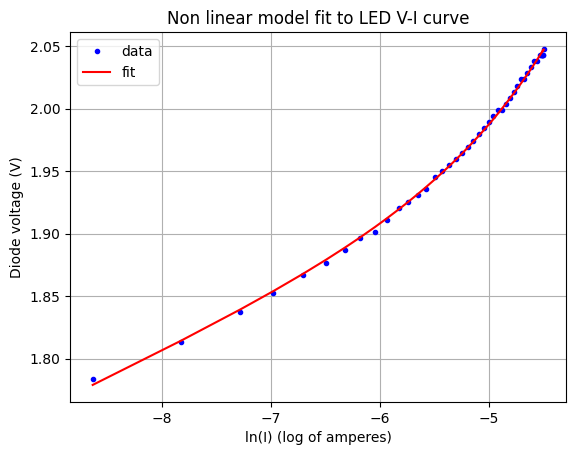

In [24]:
def linear_model_plusRint(I, A, B, Rint):
    return A*np.log(I) + B + Rint*I

lnI = np.log(Id[valid])
A0 = (Vd[valid][-1] - Vd[valid][0])/(lnI[-1] - lnI[0])
B0 = Vd[valid][0] - A0*lnI[0]
R0 = 0

(A, B, Rint), cov = curve_fit(linear_model_plusRint, Id[valid], Vd[valid], p0=[A0,B0,R0], sigma=np.ones(len(Vd[valid]))*sig)
dA,dB,dR = np.sqrt(np.diag(cov))          # returns tuple of parameters and covariance matrix

plt.plot(lnI,Vd[valid],'b.', label="data")

Vth = linear_model_plusRint(Id[valid], A, B,Rint)
plt.plot(lnI, Vth, 'r-',label="fit")
plt.title("Non linear model fit to LED V-I curve")
plt.ylabel("Diode voltage (V)")
plt.xlabel("ln(I) (log of amperes)")
plt.grid()
plt.legend()

print("A = %f +/- %f" % (A, dA))
print("B = %f +/- %f" % (B, dB))
print("Rint = %f +/- %f" % (Rint, dR))

chiSq = np.sum(((Vd[valid] - linear_model_plusRint(Id[valid], A, B, Rint))/sig)**2)
print("chiSq = %f" % (chiSq/(len(Vd[valid])-3)))


In [25]:
eta = A/kbToQ
print(eta)

lnI0 = -B/A
I0 = np.exp(lnI0)
print(I0)

1.5914643473787085
3.332116016098297e-23


(array([   3.,    7.,   15.,   68.,  162.,  319.,  587.,  837., 1203.,
        1488., 1503., 1324., 1045.,  691.,  415.,  190.,   98.,   28.,
          14.,    3.]),
 array([1.48043545, 1.49131017, 1.5021849 , 1.51305963, 1.52393435,
        1.53480908, 1.5456838 , 1.55655853, 1.56743325, 1.57830798,
        1.58918271, 1.60005743, 1.61093216, 1.62180688, 1.63268161,
        1.64355634, 1.65443106, 1.66530579, 1.67618051, 1.68705524,
        1.69792997]),
 <BarContainer object of 20 artists>)

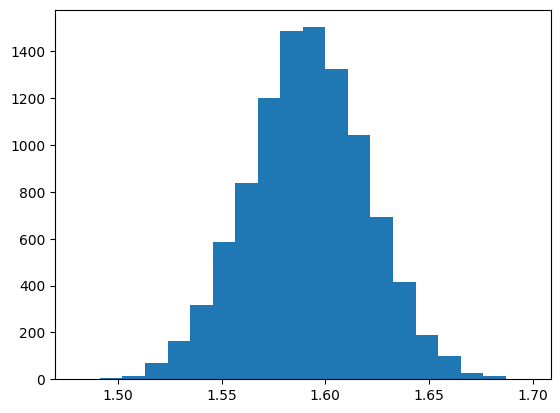

In [26]:
Amc = A + dA*np.random.normal(size=10000)
Bmc = B + dB*np.random.normal(size=10000)
etaMC = Amc/kbToQ
I0MC = np.exp(-Bmc/Amc)
plt.hist(etaMC, bins=20)

(array([6.059e+03, 2.390e+03, 8.480e+02, 3.370e+02, 1.510e+02, 9.200e+01,
        4.900e+01, 3.100e+01, 1.200e+01, 9.000e+00, 9.000e+00, 1.000e+00,
        3.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([5.90324205e-25, 4.28694736e-23, 8.51486229e-23, 1.27427772e-22,
        1.69706922e-22, 2.11986071e-22, 2.54265220e-22, 2.96544370e-22,
        3.38823519e-22, 3.81102668e-22, 4.23381818e-22, 4.65660967e-22,
        5.07940116e-22, 5.50219266e-22, 5.92498415e-22, 6.34777565e-22,
        6.77056714e-22, 7.19335863e-22, 7.61615013e-22, 8.03894162e-22,
        8.46173311e-22]),
 <BarContainer object of 20 artists>)

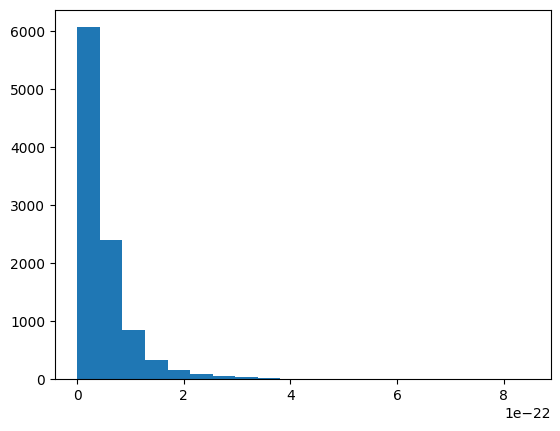

In [27]:
plt.hist(I0MC, bins=20)